In [456]:
# !pip install beautifulsoup4
# !pip install geopy
# !pip install geocoder
# !pip install folium
# !pip install selenium
# !pip install sklearn
# !pip install xlrd
# !pip install Unidecode
# !pip3 install lxml
# !pip install seaborn
# !pip install pandas_bokeh

In [1]:
import pandas as pd # library for data analysis
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
from io import BytesIO
from unidecode import unidecode
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import geopandas as gpd
from shapely.geometry import Point, Polygon
from folium import Choropleth, Circle
from folium.plugins import HeatMap

print('Libraries imported.')

Libraries imported.


In [2]:
# GeoDataFrame with geographical boundaries of Rio de Janeiro neighborhoods
neighborhoods = gpd.read_file('D:/2021/ibm/capstone_project/data/shapefile/Limite_Bairro.shp')
neighborhoods = neighborhoods[['NOME','REGIAO_ADM','CODBAIRRO','RP','geometry']]
neighborhoods.head()

,NOME,REGIAO_ADM,CODBAIRRO,RP,geometry
0,Paquetá,PAQUETA,013,Centro,"MULTIPOLYGON (((694555.510 7483079.800, 694554..."
1,Freguesia (Ilha),ILHA DO GOVERNADOR,098,Ilha do Governador,"MULTIPOLYGON (((687736.110 7480093.850, 687735..."
2,Bancários,ILHA DO GOVERNADOR,097,Ilha do Governador,"MULTIPOLYGON (((685934.980 7479388.550, 685937..."
3,Galeão,ILHA DO GOVERNADOR,104,Ilha do Governador,"MULTIPOLYGON (((681940.940 7479375.300, 681947..."
4,Tauá,ILHA DO GOVERNADOR,101,Ilha do Governador,"POLYGON ((686812.130 7477581.700, 686796.080 7..."


In [3]:
landUse = gpd.read_file('D:/2021/ibm/capstone_project/data/shapefile/Cobertura_Vegetal_e_Uso_da_Terra_2010.shp')
landUse = landUse.dissolve(by='CLASSE').reset_index()
landUse = landUse[["CLASSE","geometry"]]
urban_areas = landUse[landUse['CLASSE']=='Áreas Urbanas']
urban_areas.head()


,CLASSE,geometry
14,Áreas Urbanas,"MULTIPOLYGON (((646866.880 7448002.112, 646867..."


In [4]:
income = pd.read_excel('D:/2021/ibm/capstone_project/data/income_FGV_RJ.xls')
income.head()

,Neighborhood,PCI_FAV,PCI_TOTAL
0,Abolição,NaN,1074
1,Acari,299.0,317
2,Água Santa,319.0,853
3,Alto da Boa Vista,584.0,1253
4,Anchieta,410.0,572


In [5]:
population = pd.read_excel('D:/2021/ibm/capstone_project/data/population_RJ.xls')
population.head()

,Neighborhood,Population
0,Abolição,11356
1,Acari,27347
2,Água Santa,8756
3,Alto da Boa Vista,9343
4,Anchieta,55652


In [6]:
print('neighborhoods crs is {} \nlandUse crs is {}'.format(neighborhoods.crs, landUse.crs))

neighborhoods crs is epsg:29193 
landUse crs is epsg:31983


In [7]:
#convert neighborhood projection to SIRGAS 2000 /UTM zone 23S (epsg:31983) to match landUse projection
neighborhoods = neighborhoods.to_crs(epsg=31983)
print('neighborhoods crs is {} \nlandUse crs is {}'.format(neighborhoods.crs, landUse.crs))

neighborhoods crs is epsg:31983 
landUse crs is epsg:31983


In [8]:
income = income.rename(columns={'PCI_TOTAL':'per_capita_income'})
neighborhoods = neighborhoods.rename(columns={'NOME':'Neighborhood'})

#filter only relevant data
income = income[['Neighborhood', 'per_capita_income']]

#normalize neighborhood names
def normalizar(x):    
    result = unidecode(x).upper()
    return result
income['Neighborhood'] = income['Neighborhood'].apply(lambda x: normalizar(x))
neighborhoods['Neighborhood'] = neighborhoods['Neighborhood'].apply(lambda x: normalizar(x))
population['Neighborhood'] = population['Neighborhood'].apply(lambda x: normalizar(x))



In [9]:
population.head()

,Neighborhood,Population
0,ABOLICAO,11356
1,ACARI,27347
2,AGUA SANTA,8756
3,ALTO DA BOA VISTA,9343
4,ANCHIETA,55652


In [10]:
income.head()

,Neighborhood,per_capita_income
0,ABOLICAO,1074
1,ACARI,317
2,AGUA SANTA,853
3,ALTO DA BOA VISTA,1253
4,ANCHIETA,572


In [11]:
#join income and population data to neighborhoods geoDataFrame
neighborhoods = neighborhoods.merge(income, on='Neighborhood')
neighborhoods = neighborhoods.merge(population, on='Neighborhood')
neighborhoods.head()

,Neighborhood,REGIAO_ADM,CODBAIRRO,RP,geometry,per_capita_income,Population
0,PAQUETA,PAQUETA,013,Centro,"MULTIPOLYGON (((694510.914 7483034.188, 694510...",1052,3361
1,FREGUESIA (ILHA),ILHA DO GOVERNADOR,098,Ilha do Governador,"MULTIPOLYGON (((687691.504 7480048.235, 687691...",950,19437
2,BANCARIOS,ILHA DO GOVERNADOR,097,Ilha do Governador,"MULTIPOLYGON (((685890.372 7479342.935, 685892...",811,12512
3,GALEAO,ILHA DO GOVERNADOR,104,Ilha do Governador,"MULTIPOLYGON (((681896.326 7479329.686, 681902...",687,22971
4,TAUA,ILHA DO GOVERNADOR,101,Ilha do Governador,"POLYGON ((686767.522 7477536.082, 686751.472 7...",768,29567


In [12]:
address = 'Rio de Janeiro, RJ'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
rio_latitude = location.latitude
rio_longitude = location.longitude
print('The geograpical coordinate of Rio de Janeiro are {}, {}.'.format(rio_latitude, rio_longitude))

The geograpical coordinate of Rio de Janeiro are -22.9110137, -43.2093727.


In [13]:
# # Create a base map

# baseMap = folium.Map(location=[rio_latitude, rio_longitude], tiles='cartodbpositron', zoom_start=10)

# # Add a choropleth map to the base map
# Choropleth(geo_data=neighborhoods, 
#            data=income.set_index('Neighborhood').per_capita_income,
#            highlight = True,
#            key_on="feature.properties.Neighborhood", 
#            fill_color='YlGnBu',
#            legend_name='Per capita Income (2010) R$'
#           ).add_to(baseMap)

# # Adding labels to map
# style_function = lambda x: {'fillColor': '#ffffff', 
#                             'color':'#000000', 
#                             'fillOpacity': 0.1, 
#                             'weight': 0.1}
# SuburbName = folium.features.GeoJson(
#     neighborhoods,
#     style_function=style_function, 
#     control=False,
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['Neighborhood'
#                 ,'per_capita_income'
#                ],
#         aliases=['Neighborhood: '
#                 ,'Per Capita Income R$: '
#                  ],
#         style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
#     )
# )
# baseMap.add_child(SuburbName)
# baseMap.keep_in_front(SuburbName)
# folium.LayerControl().add_to(baseMap)
# # Display the map
# baseMap

<AxesSubplot:>

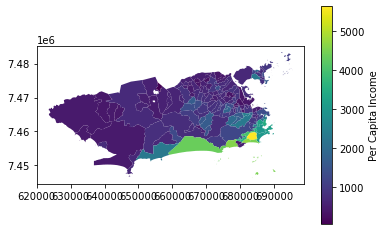

In [14]:
neighborhoods.plot(column='per_capita_income', legend=True, legend_kwds={'label': "Per Capita Income"})

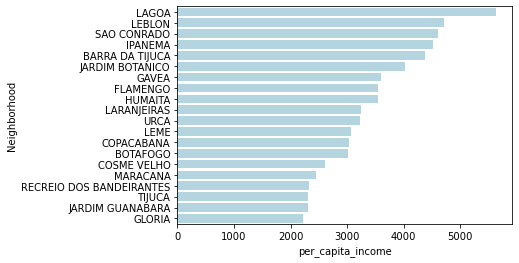

In [15]:
#top 20 per capita income neighborhoods
ax = sns.barplot(y="Neighborhood", x="per_capita_income", data=neighborhoods.sort_values(by=['per_capita_income'], ascending=False)[0:20], color="lightBlue")

In [16]:
# # Create a population map

# baseMap = folium.Map(location=[rio_latitude, rio_longitude], tiles='cartodbpositron', zoom_start=10)

# # Add a choropleth map to the base map
# Choropleth(geo_data=neighborhoods, 
#            data=neighborhoods.set_index('Neighborhood').Population,
#            key_on="feature.properties.Neighborhood", 
#            fill_color='YlGnBu',
#            legend_name='Population (IBGE_2010)'
#           ).add_to(baseMap)

# # Adding labels to map
# style_function = lambda x: {'fillColor': '#ffffff', 
#                             'color':'#000000', 
#                             'fillOpacity': 0, 
#                             'weight': 0.1}
# labels = folium.features.GeoJson(
#     neighborhoods,
#     style_function=style_function,
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['Neighborhood'
#                 ,'Population'
#                ],
#         aliases=['Neighborhood: '
#                 ,'Population: '
#                  ]
#     )
# )
# baseMap.add_child(labels)
# baseMap.keep_in_front(labels)
# folium.LayerControl().add_to(baseMap)
# # Display the map
# baseMap

<AxesSubplot:>

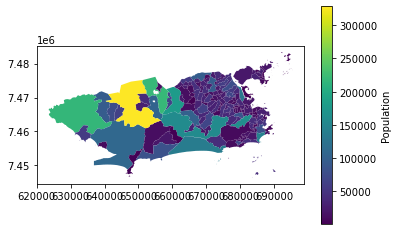

In [17]:
neighborhoods.plot(column='Population', legend=True, legend_kwds={'label': "Population"})

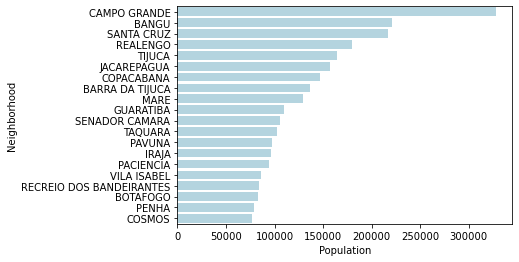

In [18]:
#top 20 population by neighborhoods
ax = sns.barplot(y="Neighborhood", x="Population", data=neighborhoods.sort_values(by=['Population'], ascending=False)[0:20], color="lightBlue")

<AxesSubplot:>

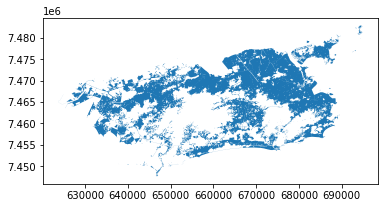

In [19]:
urban_areas.plot()

##### As we can see there are a lot of not urban areas that we need to avoid on the calculation of population density

In [20]:
#get urban areas of neighborhoods by intersecting urban area and neighborhoods polygons
urban_neighborhoods = gpd.overlay(neighborhoods, urban_areas, how='intersection')

In [21]:
urban_neighborhoods.head()

,Neighborhood,REGIAO_ADM,CODBAIRRO,RP,per_capita_income,Population,CLASSE,geometry
0,PAQUETA,PAQUETA,013,Centro,1052,3361,Áreas Urbanas,"MULTIPOLYGON (((694835.781 7482779.253, 694846..."
1,FREGUESIA (ILHA),ILHA DO GOVERNADOR,098,Ilha do Governador,950,19437,Áreas Urbanas,"MULTIPOLYGON (((689059.116 7480584.457, 689063..."
2,BANCARIOS,ILHA DO GOVERNADOR,097,Ilha do Governador,811,12512,Áreas Urbanas,"MULTIPOLYGON (((685890.372 7479342.935, 685891..."
3,GALEAO,ILHA DO GOVERNADOR,104,Ilha do Governador,687,22971,Áreas Urbanas,"MULTIPOLYGON (((683693.255 7478374.735, 683686..."
4,TAUA,ILHA DO GOVERNADOR,101,Ilha do Governador,768,29567,Áreas Urbanas,"MULTIPOLYGON (((686767.522 7477536.082, 686751..."


In [22]:
#calculate area and population density on urban areas

urban_neighborhoods['AreaKm2'] = urban_neighborhoods['geometry'].area / 10**6

urban_neighborhoods['Population_density'] = urban_neighborhoods['Population']/urban_neighborhoods['AreaKm2']
urban_neighborhoods.head()

,Neighborhood,REGIAO_ADM,CODBAIRRO,RP,per_capita_income,Population,CLASSE,geometry,AreaKm2,Population_density
0,PAQUETA,PAQUETA,013,Centro,1052,3361,Áreas Urbanas,"MULTIPOLYGON (((694835.781 7482779.253, 694846...",0.784861,4282.287905
1,FREGUESIA (ILHA),ILHA DO GOVERNADOR,098,Ilha do Governador,950,19437,Áreas Urbanas,"MULTIPOLYGON (((689059.116 7480584.457, 689063...",2.185352,8894.219756
2,BANCARIOS,ILHA DO GOVERNADOR,097,Ilha do Governador,811,12512,Áreas Urbanas,"MULTIPOLYGON (((685890.372 7479342.935, 685891...",0.942127,13280.588893
3,GALEAO,ILHA DO GOVERNADOR,104,Ilha do Governador,687,22971,Áreas Urbanas,"MULTIPOLYGON (((683693.255 7478374.735, 683686...",7.957237,2886.806067
4,TAUA,ILHA DO GOVERNADOR,101,Ilha do Governador,768,29567,Áreas Urbanas,"MULTIPOLYGON (((686767.522 7477536.082, 686751...",1.617913,18274.778958


<AxesSubplot:>

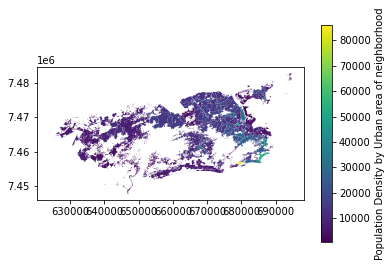

In [23]:
urban_neighborhoods.plot(column='Population_density',legend=True, legend_kwds={'label': "Population Density by Urban area of neighborhood"})

In [24]:
# # Create a new population density map considering only urban area

# baseMap = folium.Map(location=[rio_latitude, rio_longitude], tiles='cartodbpositron', zoom_start=10)

# # Add a choropleth map to the base map
# Choropleth(geo_data=urban_neighborhoods, 
#            data=urban_neighborhoods.set_index('Neighborhood').Population_density,
#            highlight = True,
#            key_on="feature.properties.Neighborhood", 
#            fill_color='YlGnBu',
#            legend_name='Population density (2010)'
#           ).add_to(baseMap)

# # Adding labels to map
# style_function = lambda x: {'fillColor': '#ffffff', 
#                             'color':'#000000', 
#                             'fillOpacity': 0,
#                             'weight': 0.1}
# SuburbName = folium.features.GeoJson(
#     urban_neighborhoods,
#     style_function=style_function, 
#     control=False,
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['Neighborhood'
#                 ,'Population_density'
#                ],
#         aliases=['Neighborhood: '
#                 ,'Population density: '
#                  ],
#         style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
#     )
# )
# baseMap.add_child(SuburbName)
# baseMap.keep_in_front(SuburbName)
# folium.LayerControl().add_to(baseMap)
# # Display the map
# baseMap

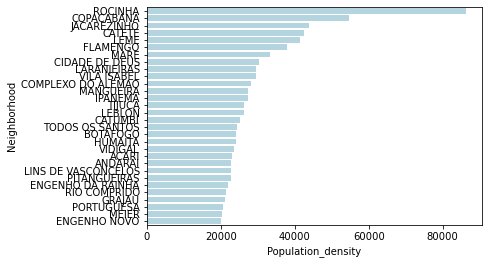

In [25]:
#top 30 population density in urban areas by neighborhoods
ax = sns.barplot(y="Neighborhood", x="Population_density", 
                 data=urban_neighborhoods.sort_values(by=['Population_density'], ascending=False)[0:30], color="lightBlue")

In [26]:
# target_areas = urban_neighborhoods[(urban_neighborhoods['Population_density']>20000) & (urban_neighborhoods['per_capita_income']>1800)]
# target_areas

In [27]:
# #target areas selected
# ax = sns.barplot(y="Neighborhood", x="Population_density", 
#                  data=target_areas.sort_values(by=['Population_density'], ascending=False), color="lightBlue")

In [28]:
# #target areas selected
# ax = sns.barplot(y="Neighborhood", x="per_capita_income", 
#                  data=target_areas.sort_values(by=['per_capita_income'], ascending=False), color="lightBlue")

In [29]:
#convert sad69 to get WGS84 lat long coordinates
urban_neighborhoods = urban_neighborhoods.to_crs(epsg=4326)

<AxesSubplot:>

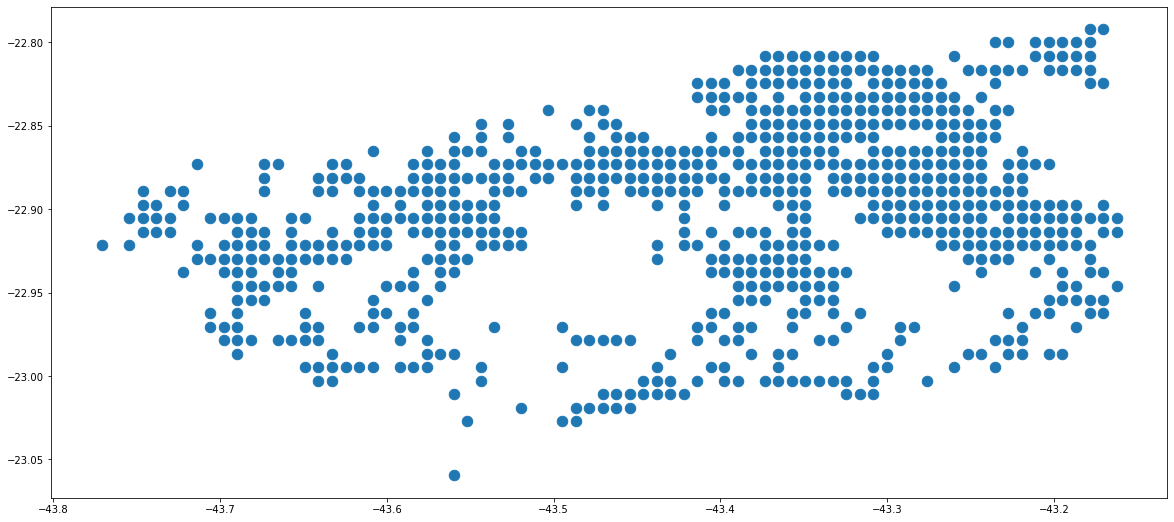

In [30]:
# make a grid of latitude-longitude values
xmin, xmax, ymin, ymax = -43.795, -43.122, -23.084, -22.792
xx, yy = np.meshgrid(np.linspace(xmin,xmax,84), np.linspace(ymin,ymax,37))
xc = xx.flatten()
yc = yy.flatten()

# Now convert these points to geo-data
pts = gpd.GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
in_map =  np.array([pts.within(geom) for geom in urban_neighborhoods.geometry]).sum(axis=0)
pts = gpd.GeoSeries([val for pos,val in enumerate(pts) if in_map[pos]])

# Plot to make sure it makes sense:
plt.rcParams["figure.figsize"] = [20,10]
pts.plot(markersize=110)

In [31]:
samples = gpd.GeoDataFrame(geometry=gpd.GeoSeries(pts))
samples.set_crs(epsg=4326, inplace=True)
samples.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  732 non-null    geometry
dtypes: geometry(1)
memory usage: 5.8 KB


In [167]:
# @hidden cell
CLIENT_ID = 'SRNZUHYHVRMEWNQBZF1B04ZJ03U40XADZ0HHY2VF2ZX3SRDE'
CLIENT_SECRET = 'IYKNJIA3CLGLYQSYV5DCKVMTOQ3K0W0NTZUUJVVW4Y5GH1DW'
# ACCESS_TOKEN = 'NELBKCB2PQA044Z41GSBUSW3THALAMTVNTUFV55XTFSVN5PD'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [33]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(categoryId, radius, samples):
    venues_list=[]
    for index, sample in samples.iterrows():
        print(index, sample.geometry)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            sample.Latitude,
            sample.Longitude,
            categoryId,
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            index,
            sample.Latitude, 
            sample.Longitude,
            v['id'],
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],
            v['location']['formattedAddress'],
            v['location']['distance'],
            v['categories'][0]['name'],
            sample.geometry) for v in results['venues']])

    nearby_venues = gpd.GeoDataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PointID',
                             'Latitude',
                             'Longitude',
                             'VenueID',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Address',
                             'Venue distance',
                             'Venue Category',
                             'geometry']
    return(nearby_venues)

In [34]:
# complementary business or services nearby
# create onehot variables for each of the folowing
# Library categoryId:4bf58dd8d48988d12f941735, 
# Bookstore categoryID:4bf58dd8d48988d114951735, 
# Post Office categoryID:4bf58dd8d48988d172941735,
# Laundromat categoryID:52f2ab2ebcbc57f1066b8b33,
# Laundry Service categoryId:4bf58dd8d48988d1fc941735
# Pet Service categoryId:5032897c91d4c4b30a586d69,
# Pet Store categoryId:4bf58dd8d48988d100951735
# Boutique categoryId:4bf58dd8d48988d104951735, 
# Museums categoryId:4bf58dd8d48988d181941735
# Art Gallery categoryId:4bf58dd8d48988d1e2931735
# Movie Theaters categoryId:4bf58dd8d48988d17f941735
# Music Stores categoryId:4bf58dd8d48988d1fe941735,
# Toy/Game Store categoryId: 4bf58dd8d48988d1f3941735,
# Comic Shop categoryId:52f2ab2ebcbc57f1066b8b18
# Sandwich Place categoryId:4bf58dd8d48988d1c5941735
# Business Center categoryId:56aa371be4b08b9a8d573517
# Community center categoryId:52e81612bcbc57f1066b7a34
# Coffee Shop categoryId:4bf58dd8d48988d1e0931735
# Café categoryId:4bf58dd8d48988d16d941735
# Parking categoryId:4c38df4de52ce0d596b336e1

# not included
# Furniture/Home Store categoryId:4bf58dd8d48988d1f8941735
# Flower Shop categoryId:4bf58dd8d48988d11b951735
# Gym/Fitness Center categoryId:4bf58dd8d48988d175941735
# Salon/Barbershop categoryId:4bf58dd8d48988d110951735

targetCategoriesId = '4bf58dd8d48988d12f941735,4bf58dd8d48988d114951735,4bf58dd8d48988d172941735,52f2ab2ebcbc57f1066b8b33,4bf58dd8d48988d1fc941735,5032897c91d4c4b30a586d69,4bf58dd8d48988d100951735,4bf58dd8d48988d104951735,4bf58dd8d48988d181941735,4bf58dd8d48988d1e2931735,4bf58dd8d48988d17f941735,4bf58dd8d48988d1fe941735,4bf58dd8d48988d1f3941735,52f2ab2ebcbc57f1066b8b18,4bf58dd8d48988d1c5941735,56aa371be4b08b9a8d573517,52e81612bcbc57f1066b7a34,4bf58dd8d48988d1e0931735,4bf58dd8d48988d16d941735,4c38df4de52ce0d596b336e1'

In [158]:
# venuesdata = getNearbyVenues(categoryId=targetCategoriesId, radius=500, samples=samples)
# venuesdata.to_csv('D:/2021/ibm/capstone_project/data/venuesdata_gdf.csv', encoding="utf-8-sig", index=False)
venuesdata = pd.read_csv('D:/2021/ibm/capstone_project/data/venuesdata.csv')
venuesdata = gpd.GeoDataFrame(venuesdata, geometry=gpd.points_from_xy(venuesdata.Longitude, venuesdata.Latitude))
venuesdata.set_crs(epsg=4326, inplace=True)
venuesdata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12379 entries, 0 to 12378
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Unnamed: 0       12379 non-null  int64   
 1   PointID          12379 non-null  int64   
 2   Latitude         12379 non-null  float64 
 3   Longitude        12379 non-null  float64 
 4   VenueID          12379 non-null  object  
 5   Venue            12379 non-null  object  
 6   Venue Latitude   12379 non-null  float64 
 7   Venue Longitude  12379 non-null  float64 
 8   Venue Address    12379 non-null  object  
 9   Venue distance   12379 non-null  int64   
 10  Venue Category   12379 non-null  object  
 11  geometry         12379 non-null  geometry
dtypes: float64(4), geometry(1), int64(3), object(4)
memory usage: 1.1+ MB


In [160]:
venuesdata.drop(columns='Unnamed: 0',inplace=True)

In [161]:
def getVenueHours(VENUE_ID):
    url = 'https://api.foursquare.com/v2/venues/{}/hours?client_id={}&client_secret={}&v={}'.format(
        VENUE_ID, 
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
        
    # make the GET request
    request = requests.get(url).json()
    if request['meta']['code'] != 200:
        print('error or quota_exceeded')
        return None
    else:
        
        results = request['response']

    #get total hours that venue is popular
        try:
            totalTime = 0
            daysOpen = []
            for timeframe in results['popular']['timeframes']:
                for day in timeframe['days']:
                    for frame in timeframe['open']:
                        daysOpen.append(day)
                        if frame['end'][0] == '+':                
                            start = pd.to_datetime(frame['start'], format='%H%M')
                            end = pd.to_datetime(frame['end'][1:], format='%H%M')
                            totalTime += pd.Timedelta(days=1).value + end.value - start.value
                        else:
                            start = pd.to_datetime(frame['start'], format='%H%M')
                            end = pd.to_datetime(frame['end'], format='%H%M')
                            totalTime += end.value - start.value
            totalPopularTimeDelta = pd.to_timedelta(totalTime)
            totalHoursPopular = pd.Timedelta(totalPopularTimeDelta).value//3600000000000
            
        except:
            print('no popular hour data for ', VENUE_ID)
            totalHoursPopular = None
            daysOpen = None
            
    if daysOpen!= None:
        daysOpen = set(daysOpen)
        daysOpen = len(daysOpen)

    return [daysOpen, totalHoursPopular]

In [162]:
coffeeShops = venuesdata[venuesdata['Venue Category'].isin(['Coffee Shop','Café'])]
# coffeeShops = coffeeShops.sort_values(by=['Venue distance'])

# coffeeShops = pd.read_csv('D:/2021/ibm/capstone_project/data/coffeeShopsTraffic_0_1094.csv')
coffeeShops = gpd.GeoDataFrame(coffeeShops, geometry=gpd.points_from_xy(coffeeShops.Longitude, coffeeShops.Latitude))
coffeeShops.set_crs(epsg=4326, inplace=True)
coffeeShops.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 394 entries, 45 to 12258
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PointID          394 non-null    int64   
 1   Latitude         394 non-null    float64 
 2   Longitude        394 non-null    float64 
 3   VenueID          394 non-null    object  
 4   Venue            394 non-null    object  
 5   Venue Latitude   394 non-null    float64 
 6   Venue Longitude  394 non-null    float64 
 7   Venue Address    394 non-null    object  
 8   Venue distance   394 non-null    int64   
 9   Venue Category   394 non-null    object  
 10  geometry         394 non-null    geometry
dtypes: float64(4), geometry(1), int64(2), object(4)
memory usage: 36.9+ KB


In [39]:
# coffeeShops.loc[3:6,['DaysOpen', 'TotalHoursOpen', 'TotalHoursPopular']] = coffeeShops.loc[3:6,['VenueID']].apply(lambda x: np.array(getVenueHours(x)))

In [40]:
# coffeeShops.to_csv('D:/2021/ibm/capstone_project/data/coffeeShopsTraffic_0_1094.csv', encoding="utf-8-sig", index=False)

In [163]:
#convert timedelta ns to hours
coffeeShopsData = coffeeShops.dropna().reset_index(drop=True)
# coffeeShopsData = pd.read_csv('D:/2021/ibm/capstone_project/data/coffeeShopsData.csv')
coffeeShopsData = gpd.GeoDataFrame(coffeeShopsData, geometry=gpd.points_from_xy(coffeeShopsData.Longitude, coffeeShopsData.Latitude))
coffeeShopsData.set_crs(epsg=4326, inplace=True)



,PointID,Latitude,Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue distance,Venue Category,geometry
0,3,-23.027222,-43.486880,58d062e55804ea0e7280afaf,California Coffee,-23.021620,-43.488318,"['Recreio Shopping (1º Piso)', 'Rio de Janeiro...",640,Coffee Shop,POINT (-43.48688 -23.02722)
1,3,-23.027222,-43.486880,55e74074498edc43b0aad4e0,Melhor Grão,-23.021134,-43.488027,"['Recreio Shopping (2º Piso)', 'Rio de Janeiro...",687,Coffee Shop,POINT (-43.48688 -23.02722)
2,7,-23.019111,-43.470663,56714d01498e7ed47aad3cd1,Pão de Queijo Minas Brasil,-23.014567,-43.470585,"['Avenida Das Américas, 16150', 'Brasil']",505,Coffee Shop,POINT (-43.47066 -23.01911)
3,8,-23.019111,-43.462554,57801d0b498e90925b872a7d,California Coffee,-23.016817,-43.460158,"['Av. Genaro de Carvalho, 1500, Lj. 3', 'Rio d...",354,Coffee Shop,POINT (-43.46255 -23.01911)
4,9,-23.019111,-43.454446,52d3c656498e22a74165868c,Sergio's Deli,-23.018177,-43.451636,['Brasil'],306,Coffee Shop,POINT (-43.45445 -23.01911)
...,...,...,...,...,...,...,...,...,...,...,...
389,723,-22.808222,-43.211193,574e0bbd498ebbeb101cfa33,Estação Nyon,-22.806790,-43.207319,"['Rua Cambauba 241', 'Brasil']",428,Coffee Shop,POINT (-43.21119 -22.80822)
390,723,-22.808222,-43.211193,5b4a7a9b46e1b6002cb9376d,Café Metro,-22.806029,-43.208746,"['Rua Cambaúba 56', 'Rio de Janeiro, RJ', '219...",350,Coffee Shop,POINT (-43.21119 -22.80822)
391,724,-22.808222,-43.203084,574e0bbd498ebbeb101cfa33,Estação Nyon,-22.806790,-43.207319,"['Rua Cambauba 241', 'Brasil']",462,Coffee Shop,POINT (-43.20308 -22.80822)
392,725,-22.808222,-43.194976,521ceb2811d2990ad14f2ae4,Cafeteria eFabrika,-22.812003,-43.193318,['Brasil'],454,Coffee Shop,POINT (-43.19498 -22.80822)


In [168]:
for index, row in coffeeShopsData.loc[100:149,['VenueID']].iterrows():
    coffeeShopsData.loc[index, ['DaysOpen', 'TotalHoursPopular']] = getVenueHours(row['VenueID'])

no popular hour data for  59594120a4ba7c5751c686ec
no popular hour data for  598c7802123a190a43dfd0ca
no popular hour data for  4b8ef7b9f964a520cb4133e3
no popular hour data for  57af7f75498ed9369b7f2888
no popular hour data for  501857e7e4b09f5054e276ed
no popular hour data for  4ffd8909e4b011cbf6e07028
no popular hour data for  57b76f8fcd109e42d3737026
no popular hour data for  58a9ef6a9f25831f738ca3f8
no popular hour data for  58a9ef6a9f25831f738ca3f8
no popular hour data for  5f5b7ee1b86b535e83dd69f1
no popular hour data for  5e68f59d227ee800087a0c8a
no popular hour data for  530b4c31498e4d77c18fe17f
no popular hour data for  4d9d0acf7509b1f712c038a0
no popular hour data for  5345ab89498ef1acf2196e77
no popular hour data for  4c6efc3dd274b60ce13ad50d
no popular hour data for  524093a611d21d5278d9d89f
no popular hour data for  52d17095498ee703e5b9330d
no popular hour data for  4d7fe043577eb1f70f059ed3
no popular hour data for  4d41cead00e8a35dbdc707fb
no popular hour data for  56b66

In [169]:
coffeeShopsData.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   PointID            394 non-null    int64   
 1   Latitude           394 non-null    float64 
 2   Longitude          394 non-null    float64 
 3   VenueID            394 non-null    object  
 4   Venue              394 non-null    object  
 5   Venue Latitude     394 non-null    float64 
 6   Venue Longitude    394 non-null    float64 
 7   Venue Address      394 non-null    object  
 8   Venue distance     394 non-null    int64   
 9   Venue Category     394 non-null    object  
 10  geometry           394 non-null    geometry
 11  DaysOpen           52 non-null     float64 
 12  TotalHoursPopular  52 non-null     float64 
dtypes: float64(6), geometry(1), int64(2), object(4)
memory usage: 40.1+ KB


In [171]:
coffeeShopsData['PopularHoursByDay'] = coffeeShopsData.TotalHoursPopular / coffeeShopsData.DaysOpen
coffeeShopsData.PopularHoursByDay.min()

6.0

In [174]:
coffeeShopsData.dropna(inplace=True)

In [173]:
coffeeShopsData.to_csv('D:/2021/ibm/capstone_project/data/coffeeShopsDatav2.csv', encoding="utf-8-sig", index=False)

In [175]:
# create map
trafficMap = folium.Map(location=[rio_latitude, rio_longitude], tiles='cartodbpositron', zoom_start=11)

def color_producer(val):
    if val <= 5:
        return 'lightblue'
    elif val > 5 and val<=7:
        return 'green'
    elif val > 7 and val <=9:
        return 'yellow'
    elif val > 9 and val <=11:
        return 'orange'
    else:
        return 'red'
    
# add markers to the map
for lat, lon, Venue, traffic in zip(coffeeShopsData['Venue Latitude'], coffeeShopsData['Venue Longitude'], coffeeShopsData['Venue'], coffeeShopsData['PopularHoursByDay']):
    label = folium.Popup('Venue:'+unidecode(Venue)+' '+'PopularHoursByDay:'+str(traffic), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=traffic**1.2,
        popup=label,
        color=color_producer(traffic),
        fill=True,
        fill_opacity=0.7).add_to(trafficMap)
    
# Add clusters to the map
# mc = MarkerCluster()
# for idx, row in coffeeShopsData.iterrows():
#     mc.add_child(Marker([row['Venue Latitude'], row['Venue Longitude']]))
# trafficMap.add_child(mc)
       
trafficMap

<AxesSubplot:xlabel='PopularHoursByDay', ylabel='Venue'>

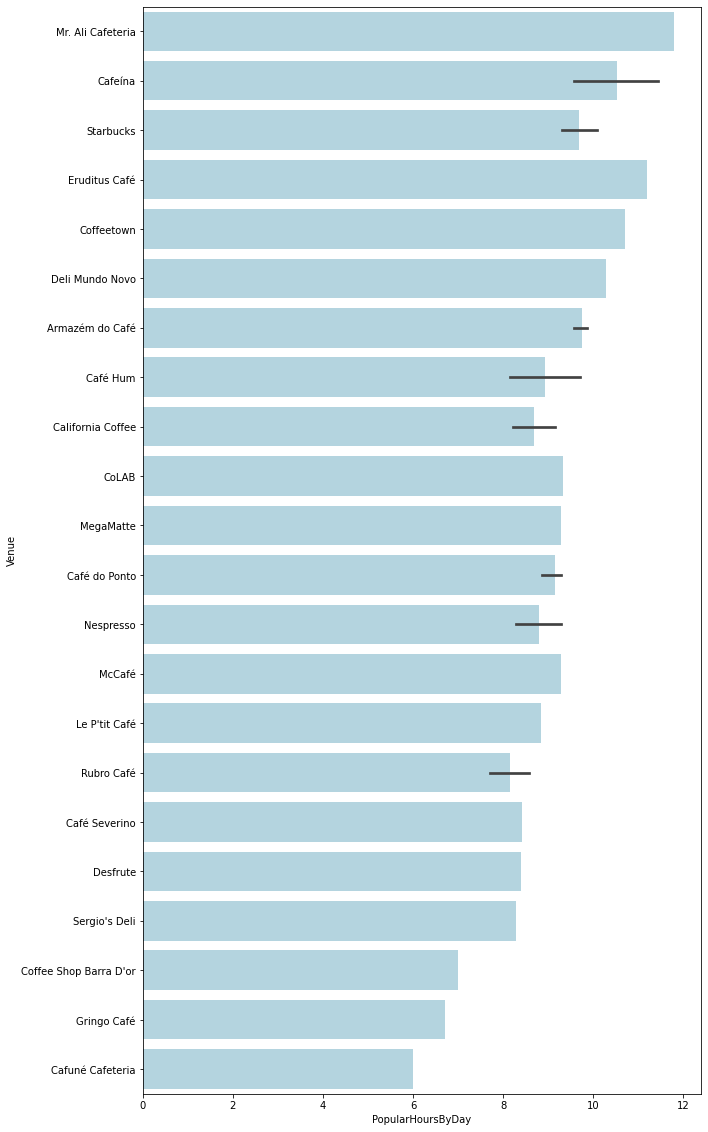

In [176]:
fig, ax = plt.subplots(figsize=(10,20))

sns.barplot(ax=ax, y="Venue", x='PopularHoursByDay', data=coffeeShopsData.sort_values(by=['PopularHoursByDay'], ascending=False), color="lightBlue")

In [81]:
# VENUE_ID = '502d662fe4b0bf3e691284ec' #starbucks shopping tijuca
# VENUE_ID2 = '4bcd8d7b511f952167bbb4c7' #gringo café copacabana
# VENUE_ID3 = '4d862de540a7a35de8a42fbe' # openHourData empty
# VENUE_ID4 = '5367dfd9498ef8d752c419d3' #no open hours (verificar amanhã)
# url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
#     VENUE_ID4, 
#     CLIENT_ID, 
#     CLIENT_SECRET, 
#     VERSION)
    
# # make the GET request
# results = requests.get(url).json()


In [82]:
# results

In [83]:
# pandas_bokeh.output_notebook()

In [84]:
# data=coffeeShopsHours.sort_values(by=['TotalTrafficHours'], ascending=False)
# data.plot_bokeh(
#     kind='barh',
#     x='Venue',
#     y='TotalTrafficHours',
#     xlabel='Total Traffic Hours',
#     ylabel='Venues',
#     title='Venues vs total traffic hours'
# )


In [85]:
# pandas_bokeh.output_file('D:/2021/ibm/capstone_project/data/chart.html')
# data.plot_bokeh(
#     kind='barh',
#     x='Venue',
#     y='TotalTrafficHours',
#     xlabel='Total Traffic Hours',
#     ylabel='Venues',
#     title='Venues vs total traffic hours'
# )

In [177]:
# coffeeShopsData = coffeeShopsData.dissolve(by='PointID', aggfunc='mean').reset_index()
# coffeeShopsData.info()
coffeeShopsData2 = coffeeShopsData.copy()
coffeeShopsData2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 52 entries, 3 to 141
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   PointID            52 non-null     int64   
 1   Latitude           52 non-null     float64 
 2   Longitude          52 non-null     float64 
 3   VenueID            52 non-null     object  
 4   Venue              52 non-null     object  
 5   Venue Latitude     52 non-null     float64 
 6   Venue Longitude    52 non-null     float64 
 7   Venue Address      52 non-null     object  
 8   Venue distance     52 non-null     int64   
 9   Venue Category     52 non-null     object  
 10  geometry           52 non-null     geometry
 11  DaysOpen           52 non-null     float64 
 12  TotalHoursPopular  52 non-null     float64 
 13  PopularHoursByDay  52 non-null     float64 
dtypes: float64(7), geometry(1), int64(2), object(4)
memory usage: 6.1+ KB


In [178]:
# coffeeShopsData.drop(columns=['Venue distance','Venue Longitude','Venue Latitude'],inplace=True)
# coffeeShopsData2.drop(columns=['Venue distance','Venue Longitude','Venue Latitude'],inplace=True)

In [179]:
# coffeeShopsData = gpd.sjoin(coffeeShopsData, urban_neighborhoods[['per_capita_income', 'Population_density','geometry']], how="inner", op='intersects')
# coffeeShopsData.head()
coffeeShopsData2 = gpd.sjoin(coffeeShopsData2, urban_neighborhoods[['per_capita_income', 'Population_density','geometry']], how="inner", op='intersects').drop(columns='index_right')
coffeeShopsData2.head()

,PointID,Latitude,Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue distance,Venue Category,geometry,DaysOpen,TotalHoursPopular,PopularHoursByDay,per_capita_income,Population_density
3,8,-23.019111,-43.462554,57801d0b498e90925b872a7d,California Coffee,-23.016817,-43.460158,"['Av. Genaro de Carvalho, 1500, Lj. 3', 'Rio d...",354,Coffee Shop,POINT (-43.46255 -23.01911),7.0,64.0,9.142857,2324,7433.105407
4,9,-23.019111,-43.454446,52d3c656498e22a74165868c,Sergio's Deli,-23.018177,-43.451636,['Brasil'],306,Coffee Shop,POINT (-43.45445 -23.01911),7.0,58.0,8.285714,2324,7433.105407
6,12,-23.011000,-43.462554,5367dfd9498ef8d752c419d3,California Coffee,-23.011642,-43.461538,"['Américas Shopping (Piso L2)', 'Rio de Janeir...",126,Coffee Shop,POINT (-43.46255 -23.01100),7.0,60.0,8.571429,2324,7433.105407
21,29,-23.002889,-43.397687,4bd584a06798ef3b4069638d,Deli Mundo Novo,-23.000738,-43.393843,"['Av. das Américas, 8445', 'Rio de Janeiro, RJ...",460,Coffee Shop,POINT (-43.39769 -23.00289),7.0,72.0,10.285714,4373,6174.538277
22,30,-23.002889,-43.389578,4e6803a77d8b084ac795cc2a,Café Severino,-23.001692,-43.386470,"['Rio Design Barra (Livraria Argumento)', 'Rio...",345,Café,POINT (-43.38958 -23.00289),7.0,59.0,8.428571,4373,6174.538277


In [180]:
coffeeShopsData2.isna().sum()

PointID               0
Latitude              0
Longitude             0
VenueID               0
Venue                 0
Venue Latitude        0
Venue Longitude       0
Venue Address         0
Venue distance        0
Venue Category        0
geometry              0
DaysOpen              0
TotalHoursPopular     0
PopularHoursByDay     0
per_capita_income     0
Population_density    0
dtype: int64

In [181]:
pointIdScore = venuesdata[venuesdata['Venue Category'].isin(['Coffee Shop','Café'])]['PointID'].value_counts().reset_index()
pointIdScore.columns=['PointID', 'Competitors_within_500m']

def calculateCompetitorScore(n_competitors):
    if n_competitors >= 1 and n_competitors<4:
        return 50
    elif n_competitors >= 4 and n_competitors < 9:
        return 40
    elif n_competitors >= 9 and n_competitors < 13:
        return 30
    elif n_competitors >= 13 and n_competitors < 17:
        return 20
    elif n_competitors >= 17:
        return 10
    else:
        return 0

    
pointIdScore['competitorScore'] = pointIdScore['Competitors_within_500m'].apply(lambda x: calculateCompetitorScore(x))
pointIdScore

,PointID,Competitors_within_500m,competitorScore
0,72,9,30
1,317,8,40
2,97,8,40
3,358,8,40
4,705,8,40
...,...,...,...
190,171,1,50
191,379,1,50
192,173,1,50
193,186,1,50


In [182]:
# coffeeShopsData2.drop(columns=['competitorScore'], inplace=True)

coffeeShopsData2 = coffeeShopsData2.merge(pointIdScore[['PointID','Competitors_within_500m']], on='PointID')
coffeeShopsData2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   PointID                  52 non-null     int64   
 1   Latitude                 52 non-null     float64 
 2   Longitude                52 non-null     float64 
 3   VenueID                  52 non-null     object  
 4   Venue                    52 non-null     object  
 5   Venue Latitude           52 non-null     float64 
 6   Venue Longitude          52 non-null     float64 
 7   Venue Address            52 non-null     object  
 8   Venue distance           52 non-null     int64   
 9   Venue Category           52 non-null     object  
 10  geometry                 52 non-null     geometry
 11  DaysOpen                 52 non-null     float64 
 12  TotalHoursPopular        52 non-null     float64 
 13  PopularHoursByDay        52 non-null     float64 
 14  per_

In [183]:
targetVenues = venuesdata[venuesdata['Venue Category'].isin(
    ['Library',
     'Bookstore',
     'Post Office',
     'Laundromat',
     'Laundry Service',
     'Pet Service',
     'Pet Store',
     'Boutique',
     'Museums',
     'Art Gallery',
     'Movie Theaters',
     'Music Stores',
     'Toy/Game Store',
     'Comic Shop',
     'Sandwich Place',
     'Business Center',
     'Community center',
     'Coffee Shop',
     'Café',
     'Parking'])]
targetVenues['Venue Category'].unique()

array(['Pet Store', 'Post Office', 'Bookstore', 'Sandwich Place',
       'Coffee Shop', 'Business Center', 'Pet Service', 'Boutique',
       'Laundry Service', 'Library', 'Laundromat', 'Art Gallery', 'Café',
       'Comic Shop'], dtype=object)

In [184]:
# venuesdata['Venue Category'].unique()

### Let's check how many venues were returned for each sample

### One Hot Encoding by Venue Category

In [185]:
# one hot encoding
# rio_onehot = pd.get_dummies(venuesdata[['Venue Category']], prefix="", prefix_sep="")
nearbyServices_onehot = pd.get_dummies(venuesdata[['Venue Category']], prefix="", prefix_sep="")
# add PointID column back to dataframe
# rio_onehot['PointID'] = venuesdata['PointID']
nearbyServices_onehot['PointID'] = venuesdata['PointID']

# move PointID column to the first column
# fixed_columns = [rio_onehot.columns[-1]] + list(rio_onehot.columns[:-1])
# rio_onehot = rio_onehot[fixed_columns]

fixed_columns = [nearbyServices_onehot.columns[-1]] + list(nearbyServices_onehot.columns[:-1])
nearbyServices_onehot = nearbyServices_onehot[fixed_columns]

nearbyServices_onehot
#print(coffeeShop_onehot)

,PointID,Acai House,Accessories Store,Animal Shelter,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Bakery,...,Swim School,Tattoo Parlor,Theater,Toy / Game Store,Track,Trade School,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12374,736,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12375,736,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12376,736,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12377,736,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by PointID and by taking the mean of the frequency of occurrence of each category

In [186]:
# nearbyServices = nearbyServices_onehot.groupby('PointID').sum().reset_index()
nearbyServicesFreq = nearbyServices_onehot.groupby('PointID').mean().reset_index()


nearbyServicesFreq.describe()

,PointID,Acai House,Accessories Store,Animal Shelter,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Bakery,...,Swim School,Tattoo Parlor,Theater,Toy / Game Store,Track,Trade School,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Yoga Studio
count,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,...,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000
mean,376.427035,0.000394,0.000129,0.000075,0.000119,0.022576,0.000916,0.000032,0.000813,0.000660,...,0.000069,0.000519,0.000031,0.003454,0.002859,0.000033,0.000125,0.000969,0.000031,0.007378
std,213.583885,0.002884,0.001651,0.001349,0.002282,0.080085,0.008627,0.000817,0.005371,0.006483,...,0.001254,0.008220,0.000800,0.015510,0.015164,0.000852,0.001885,0.006301,0.000784,0.022904
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,194.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,384.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,563.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,736.000000,0.024390,0.023810,0.026316,0.052632,1.000000,0.166667,0.020833,0.083333,0.100000,...,0.025000,0.200000,0.020408,0.250000,0.250000,0.021739,0.034483,0.083333,0.020000,0.200000


#### K Nearest Neighbor(KNN)

In [187]:
# plt.scatter(y_hat,y_test)

#### Let's write a function to sort the venues in descending order.

In [188]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's create the new dataframe and display the top 10 venues for each coffee shop.

In [189]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PointID']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
PointID_venues_sorted = pd.DataFrame(columns=columns)
PointID_venues_sorted['PointID'] = nearbyServicesFreq['PointID']

for ind in np.arange(nearbyServicesFreq.shape[0]):
    PointID_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nearbyServicesFreq.iloc[ind, :], num_top_venues)

PointID_venues_sorted

,PointID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Gym / Fitness Center,Yoga Studio,Fast Food Restaurant,Convenience Store,Corporate Coffee Shop,Cosmetics Shop,Cultural Center,Cycle Studio,Dance Studio,Dentist's Office
1,2,Yoga Studio,Gym,Salon / Barbershop,Gym / Fitness Center,Pet Store,Corporate Coffee Shop,Cosmetics Shop,Cultural Center,Cycle Studio,Drive-in Theater
2,3,Gym / Fitness Center,Salon / Barbershop,Gym,Coffee Shop,Pet Store,Toy / Game Store,Furniture / Home Store,Pilates Studio,Bookstore,Sandwich Place
3,4,Furniture / Home Store,Pet Service,Multiplex,Salon / Barbershop,Yoga Studio,Department Store,Doctor's Office,Dessert Shop,Design Studio,Dentist's Office
4,5,Gym / Fitness Center,Salon / Barbershop,Gym,Business Center,Bookstore,Pet Store,Toy / Game Store,Pilates Studio,Sandwich Place,Multiplex
...,...,...,...,...,...,...,...,...,...,...,...
646,732,Salon / Barbershop,Martial Arts School,Gym / Fitness Center,Pet Store,Boutique,Furniture / Home Store,Cosmetics Shop,Cultural Center,Cycle Studio,Dance Studio
647,733,Salon / Barbershop,Pet Store,Martial Arts School,Multiplex,Boutique,Indie Movie Theater,Art Gallery,Gym,Cycle Studio,Dance Studio
648,734,Salon / Barbershop,Pet Store,Library,Multiplex,Furniture / Home Store,Gym,Cycle Studio,Cultural Center,Dance Studio,Drive-in Theater
649,735,Salon / Barbershop,Gym / Fitness Center,Pet Store,Construction & Landscaping,Corporate Coffee Shop,Cosmetics Shop,Cultural Center,Cycle Studio,Factory,Dance Studio


## 5. training k-means with top 100 coffee shops (Clustering)
Run k-means to cluster coffee shops into 5 clusters.

In [190]:
nearbyServicesFreq

,PointID,Acai House,Accessories Store,Animal Shelter,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Bakery,...,Swim School,Tattoo Parlor,Theater,Toy / Game Store,Track,Trade School,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Yoga Studio
0,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.2
2,3,0.023256,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.046512,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.020408,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.040816,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,732,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
647,733,0.000000,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
648,734,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
649,735,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [191]:
# set number of clusters
kclusters = 7

rio_grouped_clustering = nearbyServicesFreq.drop('PointID', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(rio_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]




array([1, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 4, 2, 2, 0, 2])

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [192]:
# add clustering labels
PointID_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
rio_merged = venuesdata.groupby('PointID').mean()
# merge rio_grouped with the venuesdata to add latitude/longitude for each sample data
rio_merged = rio_merged.join(PointID_venues_sorted.set_index('PointID'), on='PointID')
rio_merged = rio_merged.reset_index()
rio_merged.head() # check the last columns!

,PointID,Latitude,Longitude,Venue Latitude,Venue Longitude,Venue distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,-23.059667,-43.559855,-23.062212,-43.564269,533.000000,1,Gym / Fitness Center,Yoga Studio,Fast Food Restaurant,Convenience Store,Corporate Coffee Shop,Cosmetics Shop,Cultural Center,Cycle Studio,Dance Studio,Dentist's Office
1,2,-23.027222,-43.494988,-23.025805,-43.495734,452.400000,2,Yoga Studio,Gym,Salon / Barbershop,Gym / Fitness Center,Pet Store,Corporate Coffee Shop,Cosmetics Shop,Cultural Center,Cycle Studio,Drive-in Theater
2,3,-23.027222,-43.486880,-23.022577,-43.488234,578.441860,2,Gym / Fitness Center,Salon / Barbershop,Gym,Coffee Shop,Pet Store,Toy / Game Store,Furniture / Home Store,Pilates Studio,Bookstore,Sandwich Place
3,4,-23.019111,-43.519313,-23.016088,-43.516903,420.400000,2,Furniture / Home Store,Pet Service,Multiplex,Salon / Barbershop,Yoga Studio,Department Store,Doctor's Office,Dessert Shop,Design Studio,Dentist's Office
4,5,-23.019111,-43.486880,-23.021317,-43.487115,362.795918,2,Gym / Fitness Center,Salon / Barbershop,Gym,Business Center,Bookstore,Pet Store,Toy / Game Store,Pilates Studio,Sandwich Place,Multiplex


In [268]:
#rio_merged = PointID_venues_sorted.join(rio_merged.set_index('PointID'), on='PointID')
rio_merged.shape

(651, 17)

#### Finally, let's visualize the resulting clusters

In [194]:
# create map
map_clusters = folium.Map(location=[rio_latitude, rio_longitude], tiles='cartodbpositron', zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, first, second, third in zip(rio_merged['Latitude'], rio_merged['Longitude'], rio_merged['PointID'], rio_merged['Cluster Labels'],
                                                       rio_merged['1st Most Common Venue'], rio_merged['2nd Most Common Venue'], rio_merged['3rd Most Common Venue']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' '+first +' '+ second +' '+ third, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [195]:
coffeeShopsData2 = coffeeShopsData2.merge(rio_merged[['PointID','Cluster Labels']], on='PointID')
coffeeShopsData2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   PointID                  52 non-null     int64   
 1   Latitude                 52 non-null     float64 
 2   Longitude                52 non-null     float64 
 3   VenueID                  52 non-null     object  
 4   Venue                    52 non-null     object  
 5   Venue Latitude           52 non-null     float64 
 6   Venue Longitude          52 non-null     float64 
 7   Venue Address            52 non-null     object  
 8   Venue distance           52 non-null     int64   
 9   Venue Category           52 non-null     object  
 10  geometry                 52 non-null     geometry
 11  DaysOpen                 52 non-null     float64 
 12  TotalHoursPopular        52 non-null     float64 
 13  PopularHoursByDay        52 non-null     float64 
 14  per_

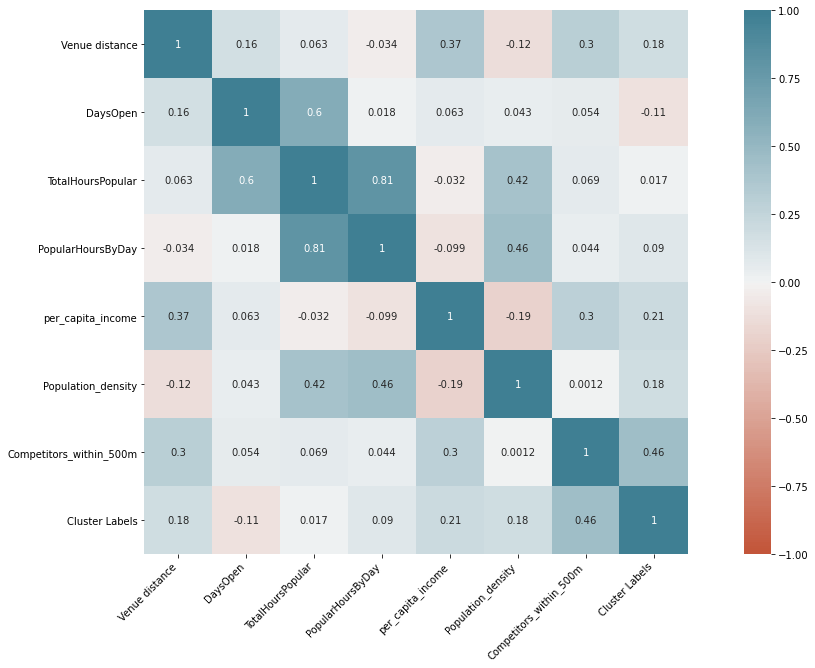

In [196]:
X = coffeeShopsData2.loc[:,['Venue distance', 'Venue Category','DaysOpen','TotalHoursPopular','PopularHoursByDay','per_capita_income','Population_density','Competitors_within_500m','Cluster Labels']]
corr = X.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [197]:
X.describe()

,Venue distance,DaysOpen,TotalHoursPopular,PopularHoursByDay,per_capita_income,Population_density,Competitors_within_500m,Cluster Labels
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,433.596154,6.750000,62.980769,9.328663,4102.153846,17250.311436,5.211538,1.884615
std,130.090656,0.589948,9.473369,1.179337,803.565935,11962.601423,2.312257,0.470871
min,126.000000,5.000000,30.000000,6.000000,2324.000000,6174.538277,1.000000,0.000000
25%,351.000000,7.000000,57.000000,8.678571,3453.500000,6174.538277,3.750000,2.000000
50%,455.500000,7.000000,64.500000,9.285714,4373.000000,13975.132634,5.000000,2.000000
75%,523.500000,7.000000,69.000000,9.857143,4632.250000,26234.422728,7.000000,2.000000
max,700.000000,7.000000,82.000000,11.800000,5635.000000,54643.139569,9.000000,2.000000


In [198]:
X.head()

,Venue distance,Venue Category,DaysOpen,TotalHoursPopular,PopularHoursByDay,per_capita_income,Population_density,Competitors_within_500m,Cluster Labels
0,354,Coffee Shop,7.0,64.0,9.142857,2324,7433.105407,1,0
1,306,Coffee Shop,7.0,58.0,8.285714,2324,7433.105407,1,0
2,126,Coffee Shop,7.0,60.0,8.571429,2324,7433.105407,5,2
3,460,Coffee Shop,7.0,72.0,10.285714,4373,6174.538277,2,2
4,345,Café,7.0,59.0,8.428571,4373,6174.538277,7,2


In [199]:
from scipy import stats
X = X.drop(columns=['Venue distance','Venue Category'])
X = X[(np.abs(stats.zscore(X)) < 3).all(axis=1)]
X.describe()

,DaysOpen,TotalHoursPopular,PopularHoursByDay,per_capita_income,Population_density,Competitors_within_500m,Cluster Labels
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.0
mean,6.760870,63.086957,9.349793,4186.782609,16442.318862,5.630435,2.0
std,0.565087,8.131765,1.069500,692.260064,9555.302653,2.058680,0.0
min,5.000000,42.000000,6.714286,2324.000000,6174.538277,1.000000,2.0
25%,7.000000,57.000000,8.714286,4373.000000,6174.538277,4.250000,2.0
50%,7.000000,64.500000,9.285714,4373.000000,19103.490174,5.000000,2.0
75%,7.000000,68.750000,9.857143,4678.750000,26234.422728,7.000000,2.0
max,7.000000,80.000000,11.800000,5635.000000,27276.652003,9.000000,2.0


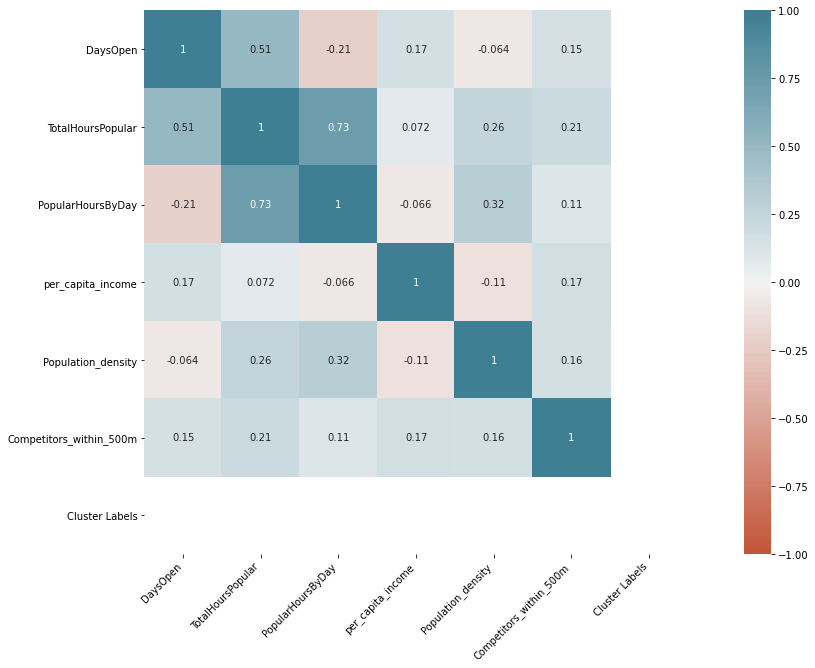

In [200]:
corr = X.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [201]:
for column in list(X.drop('PopularHoursByDay',axis=1).columns):
    pearson_coef, p_value = stats.pearsonr(X[column], X['PopularHoursByDay'])
    print(column,"Pearson Correlation:", pearson_coef, "P-value:", p_value)

DaysOpen Pearson Correlation: -0.21273576887838488 P-value: 0.15576983273536754
TotalHoursPopular Pearson Correlation: 0.7287890227429539 P-value: 9.337796570575452e-09
per_capita_income Pearson Correlation: -0.0664204246281745 P-value: 0.6609713172987884
Population_density Pearson Correlation: 0.31893022708641605 P-value: 0.030747365157909212
Competitors_within_500m Pearson Correlation: 0.11365430886502786 P-value: 0.45200959120237516
Cluster Labels Pearson Correlation: nan P-value: nan


C:\Users\felip\anaconda3\envs\geo_env\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [84]:
# ax = sns.boxplot(x="Competitors_within_500m", y="TotalTrafficHours", data=coffeeShopsData[coffeeShopsData['per_capita_income']<3000])

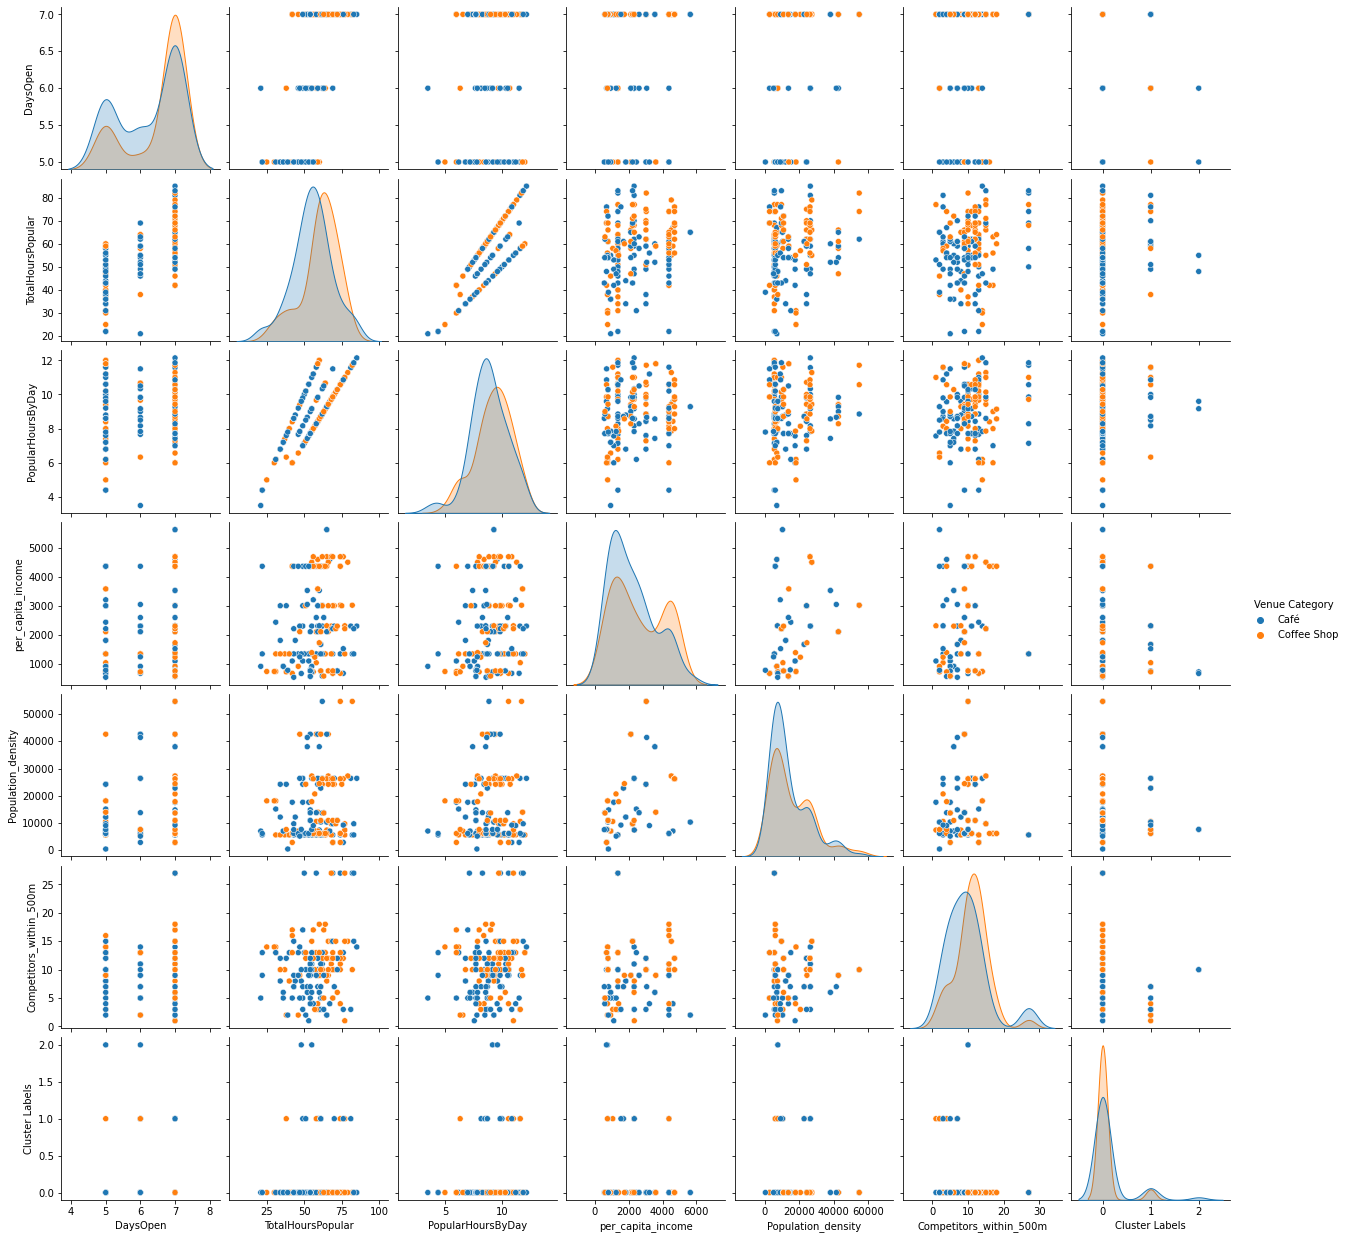

In [85]:
ax = sns.pairplot(data=X, hue='Venue Category')

In [202]:
coffeeShopsData2.head()

,PointID,Latitude,Longitude,VenueID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue distance,Venue Category,geometry,DaysOpen,TotalHoursPopular,PopularHoursByDay,per_capita_income,Population_density,Competitors_within_500m,Cluster Labels
0,8,-23.019111,-43.462554,57801d0b498e90925b872a7d,California Coffee,-23.016817,-43.460158,"['Av. Genaro de Carvalho, 1500, Lj. 3', 'Rio d...",354,Coffee Shop,POINT (-43.46255 -23.01911),7.0,64.0,9.142857,2324,7433.105407,1,0
1,9,-23.019111,-43.454446,52d3c656498e22a74165868c,Sergio's Deli,-23.018177,-43.451636,['Brasil'],306,Coffee Shop,POINT (-43.45445 -23.01911),7.0,58.0,8.285714,2324,7433.105407,1,0
2,12,-23.011000,-43.462554,5367dfd9498ef8d752c419d3,California Coffee,-23.011642,-43.461538,"['Américas Shopping (Piso L2)', 'Rio de Janeir...",126,Coffee Shop,POINT (-43.46255 -23.01100),7.0,60.0,8.571429,2324,7433.105407,5,2
3,29,-23.002889,-43.397687,4bd584a06798ef3b4069638d,Deli Mundo Novo,-23.000738,-43.393843,"['Av. das Américas, 8445', 'Rio de Janeiro, RJ...",460,Coffee Shop,POINT (-43.39769 -23.00289),7.0,72.0,10.285714,4373,6174.538277,2,2
4,30,-23.002889,-43.389578,4e6803a77d8b084ac795cc2a,Café Severino,-23.001692,-43.386470,"['Rio Design Barra (Livraria Argumento)', 'Rio...",345,Café,POINT (-43.38958 -23.00289),7.0,59.0,8.428571,4373,6174.538277,7,2


In [203]:
features = coffeeShopsData2.loc[:,['per_capita_income','Population_density','Competitors_within_500m','Cluster Labels']]
features.shape

(52, 4)

In [204]:
y=coffeeShopsData2['PopularHoursByDay'].values
y.shape

(52,)

In [257]:
from sklearn import preprocessing, ensemble
X = features
# X = preprocessing.StandardScaler().fit(X).transform(X)
# X[0:5]

In [258]:
X

,per_capita_income,Population_density,Competitors_within_500m,Cluster Labels
0,2324,7433.105407,1,0
1,2324,7433.105407,1,0
2,2324,7433.105407,5,2
3,4373,6174.538277,2,2
4,4373,6174.538277,7,2
5,4373,6174.538277,7,2
6,4373,6174.538277,7,2
7,4373,6174.538277,7,2
8,4373,6174.538277,7,2
9,4373,6174.538277,7,2


In [259]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (46, 4) (46,)
Test set: (6, 4) (6,)


In [267]:
#use random_state=46 score 0.45 mse=43.09
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_train)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, regr.predict(X_test)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination R²: %.2f'
      % regr.score(X_test, y_test))


Mean squared error: 0.35
Coefficient of determination R²: -0.34


In [239]:
poly = preprocessing.PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
regr.fit(X_train_poly, y_train)

LinearRegression()

In [240]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.3340


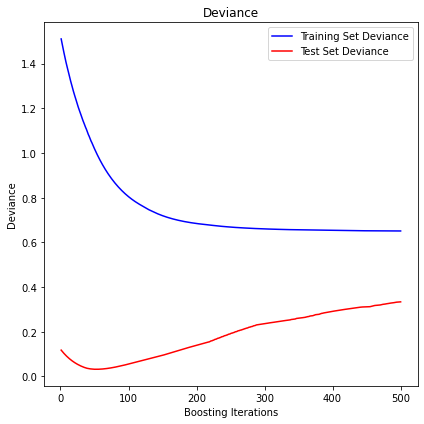

In [241]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

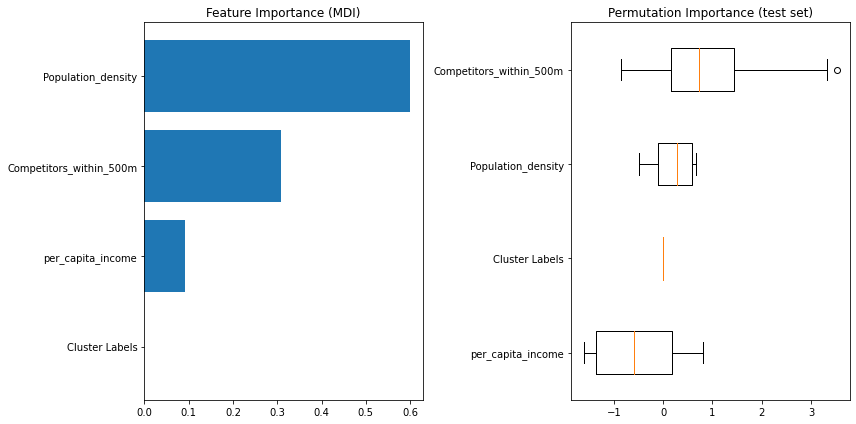

In [242]:
from sklearn.inspection import permutation_importance
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(list(X.columns))[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(list(X.columns))[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [244]:
# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1,random_state=0)
# from sklearn.ensemble import RandomForestRegressor
# clf = RandomForestRegressor()
# clf.fit(X_train, y_train)
# y_hat = clf.predict(X_test)


# # The mean squared error
# print('Mean squared error: %.2f'
#       % mean_squared_error(y_test, y_hat))
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination R²: %.2f'
#       % r2_score(y_test, y_hat))


# print("Residual sum of squares: %.2f"
#       % np.mean((y_hat - y_test) ** 2))

# # Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % clf.score(X_test, y_test))

Mean squared error: 3.00
Coefficient of determination R²: -0.12
Residual sum of squares: 3.00
Variance score: -0.12


In [219]:
# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)
# ridgeModel = linear_model.Ridge(alpha=.1)
# ridgeModel.fit(X_train, y_train)
# y_hat = ridgeModel.predict(X_test)

# # The mean squared error
# print('Mean squared error: %.2f'
#       % mean_squared_error(y_test, y_hat))
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination R²: %.2f'
#       % r2_score(y_test, y_hat))


# print("Residual sum of squares: %.2f"
#       % np.mean((y_hat - y_test) ** 2))

# # Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % ridgeModel.score(X_test, y_test))

Mean squared error: 1.46
Coefficient of determination R²: -1.04
Residual sum of squares: 1.46
Variance score: -1.04


In [220]:
# from sklearn import tree
# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
# treereg = tree.DecisionTreeRegressor()
# treereg.fit(X, y)
# y_hat = treereg.predict(X_test)

# # The mean squared error
# print('Mean squared error: %.2f'
#       % mean_squared_error(y_test, y_hat))
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination R²: %.2f'
#       % r2_score(y_test, y_hat))


# print("Residual sum of squares: %.2f"
#       % np.mean((y_hat - y_test) ** 2))

# # Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % treereg.score(X_test, y_test))

Mean squared error: 1.20
Coefficient of determination R²: 0.51
Residual sum of squares: 1.20
Variance score: 0.51


In [253]:
for i in range(len(y_hat)):
    print(y_hat[i],y_test[i])
    print(" ")

9.818225565126959 9.333333333333334
 
8.931668445085467 9.714285714285714
 
9.004874126300804 8.857142857142858
 
8.870417900142321 9.571428571428571
 
9.790778635424331 9.857142857142858
 
11.028235993184492 9.333333333333334
 


IndexError: index 6 is out of bounds for axis 0 with size 6

<AxesSubplot:>

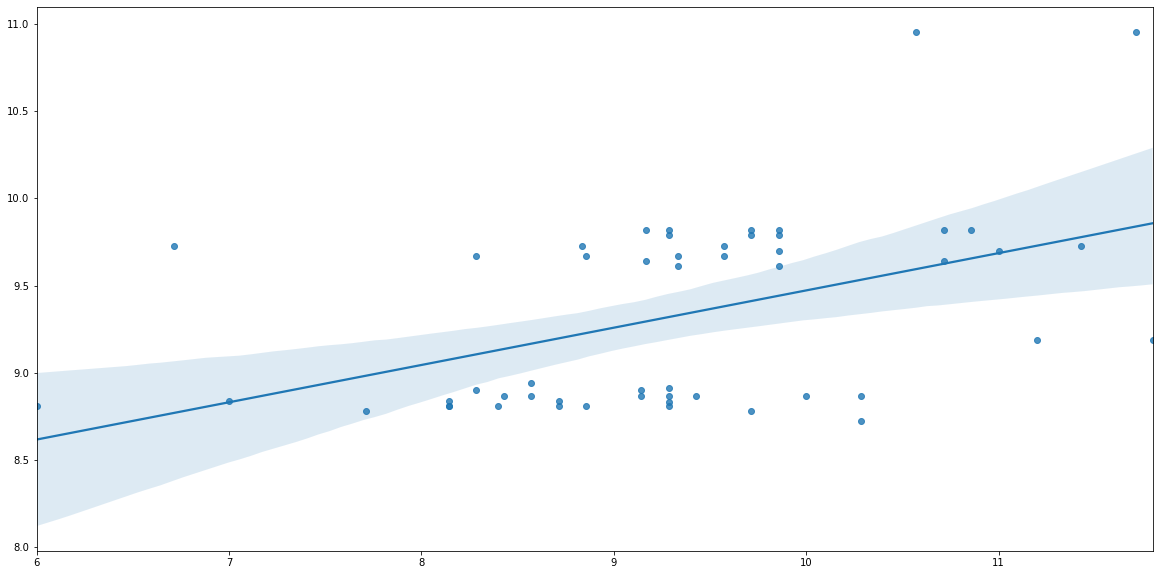

In [250]:
regr.fit(X, y)
sns.regplot(x=y, y=regr.predict(X))

In [249]:
regr.fit(X, y)

LinearRegression()

In [251]:
dataset = venuesdata.copy()
dataset = dataset.dissolve(by='PointID', aggfunc='mean').reset_index()
dataset = gpd.sjoin(dataset, urban_neighborhoods[['per_capita_income', 'Population_density','geometry']], how="inner", op='intersects')
dataset = dataset.merge(rio_merged[['PointID','Cluster Labels']], on='PointID')
dataset = dataset.join(pointIdScore.set_index('PointID'), on='PointID')
dataset = dataset.fillna(0).drop(columns=['Venue Latitude','Venue Longitude','Venue distance','index_right'])
X = dataset[['per_capita_income','Population_density','Competitors_within_500m','Cluster Labels']]
# X2 = preprocessing.StandardScaler().fit(X2).transform(X2)
dataset['PopularHoursByDay'] = regr.predict(X)
dataset

,PointID,geometry,Latitude,Longitude,per_capita_income,Population_density,Cluster Labels,Competitors_within_500m,competitorScore,PopularHoursByDay
0,0,POINT (-43.55986 -23.05967),-23.059667,-43.559855,694,2409.289458,1,0.0,0.0,8.662694
1,2,POINT (-43.49499 -23.02722),-23.027222,-43.494988,2324,7433.105407,2,0.0,0.0,8.791324
2,3,POINT (-43.48688 -23.02722),-23.027222,-43.486880,2324,7433.105407,2,2.0,50.0,8.850099
3,4,POINT (-43.51931 -23.01911),-23.019111,-43.519313,2324,7433.105407,2,0.0,0.0,8.791324
4,5,POINT (-43.48688 -23.01911),-23.019111,-43.486880,2324,7433.105407,2,0.0,0.0,8.791324
...,...,...,...,...,...,...,...,...,...,...
641,732,POINT (-43.19498 -22.80011),-22.800111,-43.194976,768,18274.778958,0,0.0,0.0,9.416120
642,733,POINT (-43.18687 -22.80011),-22.800111,-43.186867,768,18274.778958,0,0.0,0.0,9.416120
643,734,POINT (-43.17876 -22.80011),-22.800111,-43.178759,1298,10642.227773,0,0.0,0.0,9.052618
644,735,POINT (-43.17876 -22.79200),-22.792000,-43.178759,950,8894.219756,5,0.0,0.0,8.786807


In [252]:
# create map
trafficMap = folium.Map(location=[rio_latitude, rio_longitude], tiles='cartodbpositron', zoom_start=11)

def color_producer(val):
    if val <= 5:
        return 'lightblue'
    elif val > 5 and val<=7:
        return 'green'
    elif val > 7 and val <=9:
        return 'yellow'
    elif val > 9 and val <=11:
        return 'orange'
    else:
        return 'red'
    
# add markers to the map
for lat, lon, PointID, traffic in zip(dataset['Latitude'], dataset['Longitude'], dataset['PointID'], dataset['PopularHoursByDay']):
    label = folium.Popup('PointID:'+str(PointID)+' '+'PopularHoursByDay:'+str(traffic), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=traffic,
        popup=label,
        color=color_producer(traffic),
        fill=True,
        fill_opacity=0.7).add_to(trafficMap)
    
# # Add clusters to the map
# mc = MarkerCluster()
# for idx, row in coffeeShopsHours.iterrows():
#     mc.add_child(Marker([row['Venue Latitude'], row['Venue Longitude']]))
# trafficMap.add_child(mc)
       
trafficMap

In [1154]:
dataset[dataset['PointID'].isin([165,166,167])]

,PointID,geometry,Latitude,Longitude,per_capita_income,Population_density,Cluster Labels,Competitors_within_500m,TotalTrafficHours
116,166,POINT (-43.35714 -22.94611),-22.946111,-43.357145,1658,11775.281444,5,0.0,66.930110
117,167,POINT (-43.34904 -22.94611),-22.946111,-43.349036,1658,11775.281444,0,0.0,54.906756
150,165,POINT (-43.36525 -22.94611),-22.946111,-43.365253,448,30253.291416,5,1.0,68.355094
